# Benjamin Tollison

In [1]:
import os
import subprocess
import matplotlib.pyplot as plt
import numpy as np
import GPyOpt

ModuleNotFoundError: No module named 'GPyOpt'

In [2]:
def PrintAirfoil(cooridnates):
  x_coords = cooridnates[:,0]
  y_coords = cooridnates[:,1]
  
  # Print the extracted coordinates
  # print("X coordinates:", x_coords)
  # print("Y coordinates:", y_coords)

  plt.figure(figsize=(8, 6))
  plt.plot(x_coords, y_coords)
  plt.gca().set_aspect('equal', adjustable='box')
  plt.xlabel('x')
  plt.ylabel('y')
  plt.title('Modified NACA 0012bounds')
  plt.grid(True)
  plt.show()
  return None

In [3]:
def GenerateAirfoil(filename:str,thickness:float,camber:float)->list:
  """
  Modify NACA airfoil coordinates in a .dat file based on new thickness and camber parameters.
    
  Parameters:
      filename (str): Path to the .dat file containing NACA airfoil coordinates.
      new_thickness (float): New maximum thickness as a fraction of chord length (0.01 to 0.99).
      new_camber (float): New maximum camber as a fraction of chord length (0.0 to 0.05).
    
  Returns:
      numpy.ndarray: Modified NACA airfoil coordinates (x, y).
  """
  # Read existing airfoil coordinates from the .dat file
  airfoil_coords = np.loadtxt(f"{filename}.dat")
    
  # Scale coordinates based on new thickness and camber parameters
  x = airfoil_coords[:, 0]
  y = airfoil_coords[:, 1]
  x_scaled = x
  y_scaled = y * (thickness / 0.12)  # Scale thickness
  y_scaled += (camber / 0.02) * 0.12 * (0.2969 * np.sqrt(x) - 0.1260 * x - 0.3516 * x ** 2 + 0.2843 * x ** 3 - 0.1015 * x ** 4)  # Scale camber
    
  # Combine scaled coordinates into a new array
  modified_airfoil_coords = np.column_stack([x_scaled, y_scaled])
  # Save modified airfoil coordinates to a new .dat file
  modified_filename = f"modified_{filename}.dat"
  np.savetxt(modified_filename, modified_airfoil_coords, fmt=['    %1.6f','%1.6f'], delimiter='    ')#, header=f"Modified Airfoil: {filename}", comments='')
  return modified_airfoil_coords

In [4]:
def LiftDragRatio(polar_input_dict):
  alpha = polar_input_dict['alpha']
  cl = polar_input_dict['CL']
  cd = polar_input_dict['CD']
  lift_over_drag_discrete = []
  for index in range(len(cl)):
    lift_over_drag_discrete.append(cl[index]/cd[index])
  polyfit_coeffiecients = np.polyfit(alpha,lift_over_drag_discrete,5)
  return np.poly1d(polyfit_coeffiecients)

In [5]:
def ObjectiveFunction(input_vector):
  thickness, camber = input_vector[0], input_vector[1]
  # params for XFOIL
  base_airfoil_file = 'NACA0012'
  airfoil_name = 'modified_NACA0012'
  #airfoil_name = 'NACA0012'
  alpha_i = 0
  alpha_f = 10
  alpha_step = 0.25
  Re = 1000000
  n_iter = 200

  new_coords = GenerateAirfoil(base_airfoil_file,thickness,camber)
  PrintAirfoil(new_coords)
  # Read the airfoil coordinate file
  with open("modified_NACA0012.dat", "r") as file:
    lines = file.readlines()

  # Remove duplicate points
  unique_lines = []
  for line in lines:
    if line not in unique_lines:
      unique_lines.append(line)

  # Write the modified airfoil coordinate file
  with open("modified_NACA0012.dat", "w") as file:
    file.writelines(unique_lines)

  # %% XFOIL input file writer

  if os.path.exists("polar_file.txt"):
    os.remove("polar_file.txt")
  # Create a dummy xfoil.def file
  # with open("xfoil.def", "w") as file:
    # file.write("This is a dummy xfoil.def file.")


  input_file = open("input_file.in", 'w')
  input_file.write("LOAD {0}.dat\n".format(airfoil_name))
  input_file.write(airfoil_name + '\n')
  input_file.write("PANE\n")
  input_file.write("OPER\n")
  input_file.write("Visc {0}\n".format(Re))
  input_file.write("PACC\n")
  input_file.write("polar_file.txt\n\n")
  input_file.write("ITER {0}\n".format(n_iter))
  input_file.write("ASeq {0} {1} {2}\n".format(alpha_i, alpha_f,alpha_step))
  input_file.write("\n\n")
  input_file.write("quit\n")
  input_file.close()
  # print('XFOIL is loading...')
  # subprocess.call("xfoil.exe < input_file.in", shell=True)
  # print('XFOIL is being executed')
  try:
    output = subprocess.check_output("xfoil.exe < input_file.in", shell=True, stderr=subprocess.STDOUT)
    print("XFOIL output:", output)
  except subprocess.CalledProcessError as e:
    print("Error executing XFOIL command:", e.output)

  polar_data = np.loadtxt("polar_file.txt", skiprows=12)
  data = {}
  data["alpha"] = polar_data[:, 0]
  data["CL"] = polar_data[:, 1]
  data["CD"] = polar_data[:, 2]
  data["CDp"] = polar_data[:, 3]
  data["CM"] = polar_data[:, 4]
  data["Top_Xtr"] = polar_data[:, 5]
  data["Bot_Xtr"] = polar_data[:, 6]

  lift_over_drag_function = LiftDragRatio(data)
  design_angle_of_attack = 3 #degrees
  lift_over_drag = lift_over_drag_function(design_angle_of_attack)
  return lift_over_drag


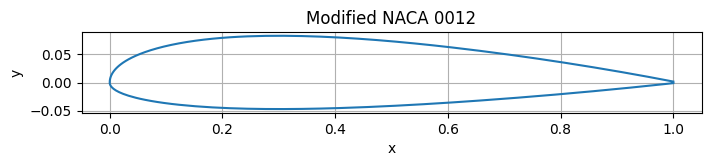

XFOIL output: b'\r\n ===================================================\r\n  XFOIL Version 6.99\r\n  Copyright (C) 2000   Mark Drela, Harold Youngren\r\n\r\n  This software comes with ABSOLUTELY NO WARRANTY,\r\n    subject to the GNU General Public License.\r\n\r\n  Caveat computor\r\n ===================================================\r\n\r\n File  xfoil.def  not found\r\n\r\n   QUIT    Exit program\r\n\r\n  .OPER    Direct operating point(s)\r\n  .MDES    Complex mapping design routine\r\n  .QDES    Surface speed design routine\r\n  .GDES    Geometry design routine\r\n\r\n   SAVE f  Write airfoil to labeled coordinate file\r\n   PSAV f  Write airfoil to plain coordinate file\r\n   ISAV f  Write airfoil to ISES coordinate file\r\n   MSAV f  Write airfoil to MSES coordinate file\r\n   REVE    Reverse written-airfoil node ordering\r\n\r\n   LOAD f  Read buffer airfoil from coordinate file\r\n   NACA i  Set NACA 4,5-digit airfoil and buffer airfoil\r\n   INTE    Set buffer airfoil by i

74.72584562619792

In [6]:
ObjectiveFunction([0.13,0.03])

In [ ]:
domain = [
  {'name':'thickness','type':'continuous','domain':(0.1,0.18)},
  {'name':'camber','type':'continuous','domain':(0.02,0.05)}
]

optimizer = 